# Imports:

In [1]:
!pip install tensorflow_addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, preprocessing, losses
import matplotlib.pyplot as plt
from os import listdir, mkdir, path
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from termcolor import colored

# Load Coin Dataset:

In [34]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/MyDrive/coin_classifier/'

# Local
base_dir = '.'

dataset_dir = '%s/images/' % base_dir
model_dir = '%s/coin_classifier_model/' % base_dir

In [5]:
class RandomBrightness(layers.Layer):
  def __init__(self, delta, **kwargs):
    super(RandomBrightness, self).__init__(**kwargs)
    self.delta = delta

  def __call__(self, images, **kwargs):
    def random_brightness(image):
      return tf.image.random_brightness(image, self.delta)
    images = tf.map_fn(random_brightness, images)
    return tf.clip_by_value(images, 0, 1)

class RandomContrast(layers.Layer):
  def __init__(self, range, **kwargs):
    super(RandomContrast, self).__init__(**kwargs)
    self.range = range

  def __call__(self, images, **kwargs):
    def random_contrast(image):
      return tf.image.random_contrast(image, self.range[0], self.range[1])
    images = tf.map_fn(random_contrast, images)
    return tf.clip_by_value(images, 0, 1)

augment = models.Sequential([
  layers.RandomZoom((0, 0.2), fill_mode="constant", fill_value=1),
  layers.RandomRotation(0.05, fill_mode="constant", fill_value=1),
  layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=1),
  RandomBrightness(0.2),
  RandomContrast((0.8, 1))
])

2021-10-23 01:54:00.571388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
batch_size = 64
img_size = 128

labels = open('%s/coin_classifier_labels.txt' % base_dir).readlines()
labels = list(map(lambda x: x.strip(), labels))

dataset = preprocessing.image_dataset_from_directory(
  '%s/images/' % base_dir,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
)
dataset = dataset.map(lambda image, label: (image / 255.0, label))
datasets = [dataset] + [dataset.map(lambda image, label: (augment(image), label)) for _ in range(9)]
dataset = tf.data.experimental.sample_from_datasets(datasets)

Found 4070 files belonging to 84 classes.


# Display Coin Images:

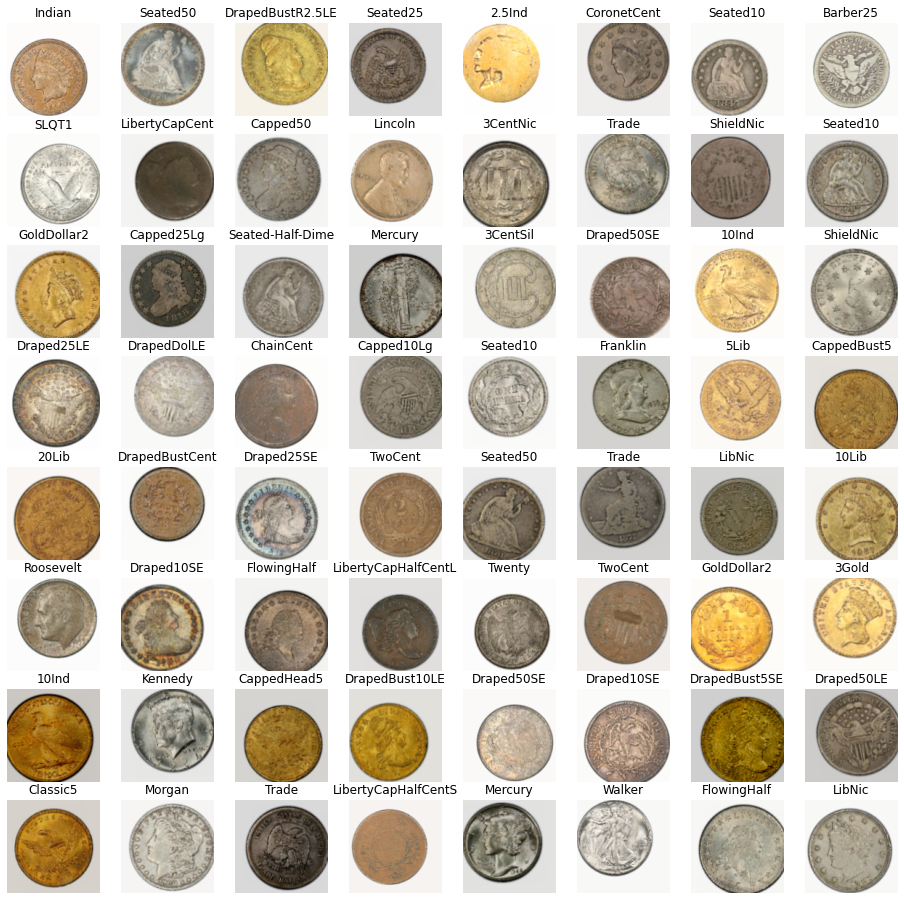

In [22]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = next(dataset.as_numpy_iterator())
for i in range(batch_size):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[y_batch[i]])

# Create CNN:

In [45]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(84),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)       

# Train Model:

In [ ]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(dataset, epochs=10)

# Save/Load Model:

## Save model:

In [ ]:
model.save('%s/coin_classifier_save' % base_dir)

## Save model using TFLite:

In [36]:
converter = tf.lite.TFLiteConverter.from_saved_model('%s/coin_classifier_save' % base_dir)
tflite_model = converter.convert()
with open('%s/coin_classifier.tflite' % base_dir, 'wb') as f:
  f.write(tflite_model)

2021-10-23 02:16:56.374796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-23 02:16:56.374813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-10-23 02:16:56.374817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-10-23 02:16:56.378038: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./coin_classifier_save
2021-10-23 02:16:56.384552: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-23 02:16:56.384573: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./coin_classifier_save
2021-10-23 02:16:56.405752: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-10-23 02:16:56.514504: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: ./coin_c

## Load model:

In [17]:
model = models.load_model('%s/coin_classifier_save' % base_dir)

## Load model using TFLite:

In [37]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='%s/coin_classifier.tflite' % base_dir)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

In [18]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

2021-10-23 01:59:30.060171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10Ind: 1.00
10Lib: 0.90
1793HalfCent: 0.83
2.5Ind: 0.94
2.5Lib: 0.96
20Lib: 0.93
20Saint: 0.99
3CentNic: 0.99
3CentSil: 0.94
3Gold: 0.97
5Ind: 0.83
5Lib: 0.88
Barber10: 0.96
Barber25: 0.88
Barber50: 0.94
BraidedCent: 0.88
BraidedHalfCent: 0.93
Buffalo: 0.99
Capped10Lg: 0.85
Capped2.5: 0.92
Capped25Lg: 0.48
Capped50: 0.94
CappedBust5: 0.87
CappedHalfDime: 0.90
CappedHead5: 0.90
ChainCent: 0.87
Classic2.5: 0.94
Classic5: 0.88
ClassicCent: 0.87
ClassicHalfCent: 0.73
CoronetCent: 0.86
Draped10LE: 0.77
Draped10SE: 0.68
Draped25LE: 0.88
Draped25SE: 0.79
Draped50LE: 0.72
Draped50SE: 0.73
DrapedBust10LE: 0.80
DrapedBust10SE: 0.97
DrapedBust5LE: 0.70
DrapedBust5SE: 0.69
DrapedBustCent: 0.86
DrapedBustR2.5LE: 0.90
DrapedDolLE: 0.82
DrapedHalfCent: 0.82
DrapedHalfDime: 0.36
DrapedHalfDimeLE: 0.65
FlowingDol: 0.73
FlowingHalf: 0.88
FlowingHalfDime: 0.86
Flying: 0.95
Franklin: 0.99
GoldDollar1: 0.99
GoldDollar2: 0.83
GoldDollar3: 0.82
Ike: 0.89
Indian: 0.97
Jefferson: 0.93
Kennedy: 0.97
LibNic: 0.9

1: 3CentNic
2: Seated-Half-Dime
3: Walker
4: Morgan
5: SLQT1


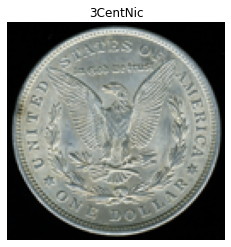

In [65]:
img_name = 'Morgan_r.jpg'
label = img_name.split('_')[0]

img = Image.open('%s/test_images/%s' % (base_dir, img_name))
w, h = img.size
top = (h - w) / 2
img = img.crop((0, top, w, top + w)).resize(size=(img_size, img_size))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)
img_dataset = tf.data.Dataset.from_tensors([img_data])

# For Standard Model
prediction = model.predict(img_dataset)[0]

# For TFLite Model
# interpreter.set_tensor(input_details[0]['index'], [img_data])
# interpreter.invoke()
# prediction = interpreter.get_tensor(output_details[0]['index'])[0]

ranked = np.argsort(prediction)

def get_color(index):
  if index == -1:
    return 'green' if labels[ranked[index]] == label else 'red'
  else:
    return 'yellow' if labels[ranked[index]] == label else 'white'

for i in range(-1,-6,-1):
  print(colored('%d: %s' % (abs(i), labels[ranked[i]]), get_color(i)))

plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)